## Repères du notebook
    
   1. [Introduction](#introduction)
   
      [Observation des différences de colonnes](#obs)
      
      [Séparation de "location" dans data15](#loc)
      
      [Passage à un seul dataframe](#df)
      
      [Nettoyage: supression des bâtiments résidentiels](#res)
      
      [Nettoyage: doublons identifiants batiments](#double)
      
      
   
   2. [ Traitement valeurs manquantes et aberrantes ](#p1)
   
       [Valeurs manquantes: drop colonnes selon remplissage des variables](#var)
       
       [Nettoyage: forte corrélation des variables explicatives](#corr)
       
       [Nettoyage: intérêt faible des variables pour projet](#bof)
       
       [Nettoyage: individus avec valeurs manquantes et "outliers" pour variables à prédire](#drop)
       
   
   3. [Feature engineering et traitement des données](#p2)
       
      [age des batiments à partir de l'année des données et l'année de construction](#âge)
      
      [Passage au log des targets](#log)
      
      [séparation du dataframe par types de données](#sep)
      
      
   
   4. [Contrôle et export des données nettoyées](#p3)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.impute import KNNImputer
import statsmodels.formula.api
import statsmodels.api
import six
import dataframe_image as dfi
import scipy.stats as stats

plt.style.use('seaborn-whitegrid')

#options d'affichage
pd.set_option('display.max_row', 200)
pd.set_option('display.max_column', 70)

## 1. Introduction: Chargement des données et observations <a class="anchor" id="introduction"></a>

In [5]:
data_15 = pd.read_csv('../données/building-energy-benchmarking-15.csv')
data_16 = pd.read_csv('../données/building-energy-benchmarking-16.csv')

In [6]:
data_15.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [7]:
data_16.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [8]:
data_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [9]:
data_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [10]:
print(data_15.columns)
data_15.shape

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'DefaultData', '

(3340, 47)

In [11]:
data_16.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

## Observation des différences de colonnes <a class="anchor" id="obs"></a>

In [12]:
#on cherche les différences de colonnes entre les deux dataframes
mis_col = data_15.columns[~data_15.columns.isin(data_16.columns)]

In [13]:
mis_col

Index(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes'],
      dtype='object')

In [14]:
#la colonne location de 2015 contient de nombreuses informations séparées dans le dataframe de 2016
data_15['Location']

0       {'latitude': '47.61219025', 'longitude': '-122...
1       {'latitude': '47.61310583', 'longitude': '-122...
2       {'latitude': '47.61334897', 'longitude': '-122...
3       {'latitude': '47.61421585', 'longitude': '-122...
4       {'latitude': '47.6137544', 'longitude': '-122....
                              ...                        
3335    {'latitude': '47.59950256', 'longitude': '-122...
3336    {'latitude': '47.65752471', 'longitude': '-122...
3337    {'latitude': '47.61649845', 'longitude': '-122...
3338    {'latitude': '47.68396954', 'longitude': '-122...
3339    {'latitude': '47.68396954', 'longitude': '-122...
Name: Location, Length: 3340, dtype: object

In [15]:
data_15['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

## Séparation de "location" dans data15 <a class="anchor" id="loc"></a>

In [16]:
#on utrilise le module abstract syntax trees pour désempacter "location" puis "human address" avec des listes en compréhensions
import ast
data_15['Location'] = [ast.literal_eval(str(item)) for index, item in data_15.Location.iteritems()]
data_15 = pd.concat([data_15.drop(['Location'], axis=1), data_15['Location'].apply(pd.Series)], axis=1)

data_15['human_address'] = [ast.literal_eval(str(item)) for index, item in data_15.human_address.iteritems()]
data_15 = pd.concat([data_15.drop(['human_address'], axis=1), data_15['human_address'].apply(pd.Series)], axis=1)
data_15.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,latitude,longitude,address,city,state,zip
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,WA,98101
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,WA,98121


In [17]:
#Renommer pour que les colonnes correspondent:
data_15 = data_15.rename(columns={"latitude":"Latitude", 
                                  "longitude":"Longitude",
                                  "address":"Address", 
                                  "city":"City", 
                                  "state":"State", 
                                  "zip":"ZipCode"})

In [18]:
#Est-ce qu'elles correspondent aux mêmes informations?
print(data_15['GHGEmissions(MetricTonsCO2e)'].describe())
data_15['GHGEmissionsIntensity(kgCO2e/ft2)'].describe()

count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64


count    3330.000000
mean        0.985339
std         1.637172
min         0.000000
25%         0.080000
50%         0.460000
75%         1.180000
max        31.380000
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64

In [19]:
print(data_16['TotalGHGEmissions'].describe())
data_16['GHGEmissionsIntensity'].describe()

count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64


count    3367.000000
mean        1.175916
std         1.821452
min        -0.020000
25%         0.210000
50%         0.610000
75%         1.370000
max        34.090000
Name: GHGEmissionsIntensity, dtype: float64

## Passage à un seul dataframe<a class="anchor" id="df"></a>

In [20]:
#Renommer:
data_15 = data_15.rename(columns={'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions',
                                  'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity',
                                  'Comment':'Comments'})

In [21]:
# drop colonnes qui ne sont pas dans les deux dataframe
mis_col = data_15.columns[~data_15.columns.isin(data_16.columns)]
print(mis_col)
data_15.drop(mis_col, axis=1, inplace=True)

Index(['OtherFuelUse(kBtu)', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes'],
      dtype='object')


In [22]:
#on vérifie les types avent la concaténation

In [23]:
dtypes = pd.DataFrame([data_15.dtypes, data_16.dtypes])
dtypes

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
0,int64,int64,object,object,object,object,int64,object,int64,int64,float64,int64,int64,int64,object,object,float64,object,float64,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object
1,int64,int64,object,object,object,object,int64,object,int64,float64,int64,int64,int64,int64,object,object,float64,object,float64,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,object,object,float64,float64,object,object,object,float64


In [24]:
#On recast pour que les dtypes correspondent:
data_15[['Latitude','Longitude', 'ZipCode']] = data_15[['Latitude','Longitude', 'ZipCode']].astype('float64')

In [25]:
data_16.columns[data_16.columns.isin(data_15.columns)]

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [26]:
#Assembler les deux dataframes:
r_data = pd.concat([data_15[data_16.columns],data_16], axis = 0).sort_values(["DataYear", "OSEBuildingID"])
r_data.shape

(6716, 46)

In [27]:
r_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   Address                          6716 non-null   object 
 6   City                             6716 non-null   object 
 7   State                            6716 non-null   object 
 8   ZipCode                          6700 non-null   float64
 9   TaxParcelIdentificationNumber    6714 non-null   object 
 10  CouncilDistrictCode              6716 non-null   int64  
 11  Neighborhood                     6716 non-null   object 
 12  Latitude            

## Nettoyage: supression des bâtiments résidentiels<a class="anchor" id="res"></a>

In [28]:
#on s'intéresse au batiments "non-habitations" pour ce projet:
r_data['BuildingType'].unique()


array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [29]:
r_data = r_data[~r_data['BuildingType'].str.contains("Multifamily")]
r_data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [30]:
r_data.shape

(3318, 46)

## Nettoyage: doublons identifiants batiments<a class="anchor" id="double"></a>

In [31]:
#bonne idée reprise ici: se débarasser des batiments en double mais en conservant une moyenne des données continues pour saisir
#une part de l'information: l'évolution entre l'année 2015 et 2016:

mean_columns = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
                'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
                'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
                'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
                'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']
OSEBuilding_means = r_data[['OSEBuildingID']+mean_columns].groupby('OSEBuildingID').mean()
OSEBuilding_means.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,
1,1.0,12.0,88434.0,0.0,88434.0,88434.0,NaN,NaN,62.5,80.299998,82.300002,178.000000,182.050000,7103895.25,7277224.50,2.013457e+06,1.118411e+06,3816093.5,12744.264650,1274420.5,249.705,2.735
2,1.0,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,4622.0,56.0,94.600002,98.450001,183.700003,187.299997,8371084.00,8715133.50,0.000000e+00,1.047494e+06,3574131.0,47970.408205,4797033.5,279.685,2.620
3,1.0,41.0,959050.0,98359.0,860691.0,756868.0,100000.0,0.0,30.5,96.300000,98.699998,242.299997,245.300003,72858840.00,74721692.00,2.061348e+07,1.454968e+07,49644549.5,26018.500000,2601850.0,2075.380,2.055
5,1.0,10.0,61320.0,0.0,61320.0,61320.0,NaN,NaN,28.5,285.600002,287.900002,426.249998,433.600000,17511952.00,17655122.25,1.283648e+07,8.115232e+05,2768973.5,19065.565430,1906553.5,1111.385,18.025
8,1.0,18.0,147735.0,37230.0,110505.0,123445.0,68009.0,0.0,71.0,117.450002,120.399998,220.099997,221.350003,14500852.50,14867373.00,0.000000e+00,1.675645e+06,5717426.0,87835.492190,8783551.5,506.355,3.450


In [32]:
#drop les doublons sur l'id des batiments et concaténation des moyennes entre les deux années:
duplicate_building = r_data.drop_duplicates(subset=['OSEBuildingID'], keep='last')
duplicate_building.drop(mean_columns, axis=1, inplace=True)
r_data = pd.merge(duplicate_building, OSEBuilding_means, how='left', on='OSEBuildingID')

C:\Users\Adnene\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
#Vérification pour assurer qu'il n'y ait pas de grosses erreurs:
r_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698 entries, 0 to 1697
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1698 non-null   int64  
 1   DataYear                         1698 non-null   int64  
 2   BuildingType                     1698 non-null   object 
 3   PrimaryPropertyType              1698 non-null   object 
 4   PropertyName                     1698 non-null   object 
 5   Address                          1698 non-null   object 
 6   City                             1698 non-null   object 
 7   State                            1698 non-null   object 
 8   ZipCode                          1682 non-null   float64
 9   TaxParcelIdentificationNumber    1698 non-null   object 
 10  CouncilDistrictCode              1698 non-null   int64  
 11  Neighborhood                     1698 non-null   object 
 12  Latitude            

## 2. Traitement valeurs manquantes et aberrantes <a class="anchor" id="p1"></a>

## Valeurs manquantes: remplissage des variables<a class="anchor" id="var"></a>

In [34]:
#nombre total et pourcentage de valeurs manquantes dans le df 
def perc_mv(data):
    Tot_missing_values = data.isna().sum().sum()
    print('total valeurs manquantes: {} '.format(Tot_missing_values))
    Tot_perc_missing_values = (Tot_missing_values/np.product(data.shape))*100
    return Tot_perc_missing_values

In [35]:
perc_mv(r_data)

total valeurs manquantes: 9921 


12.701643877707788

<AxesSubplot:>

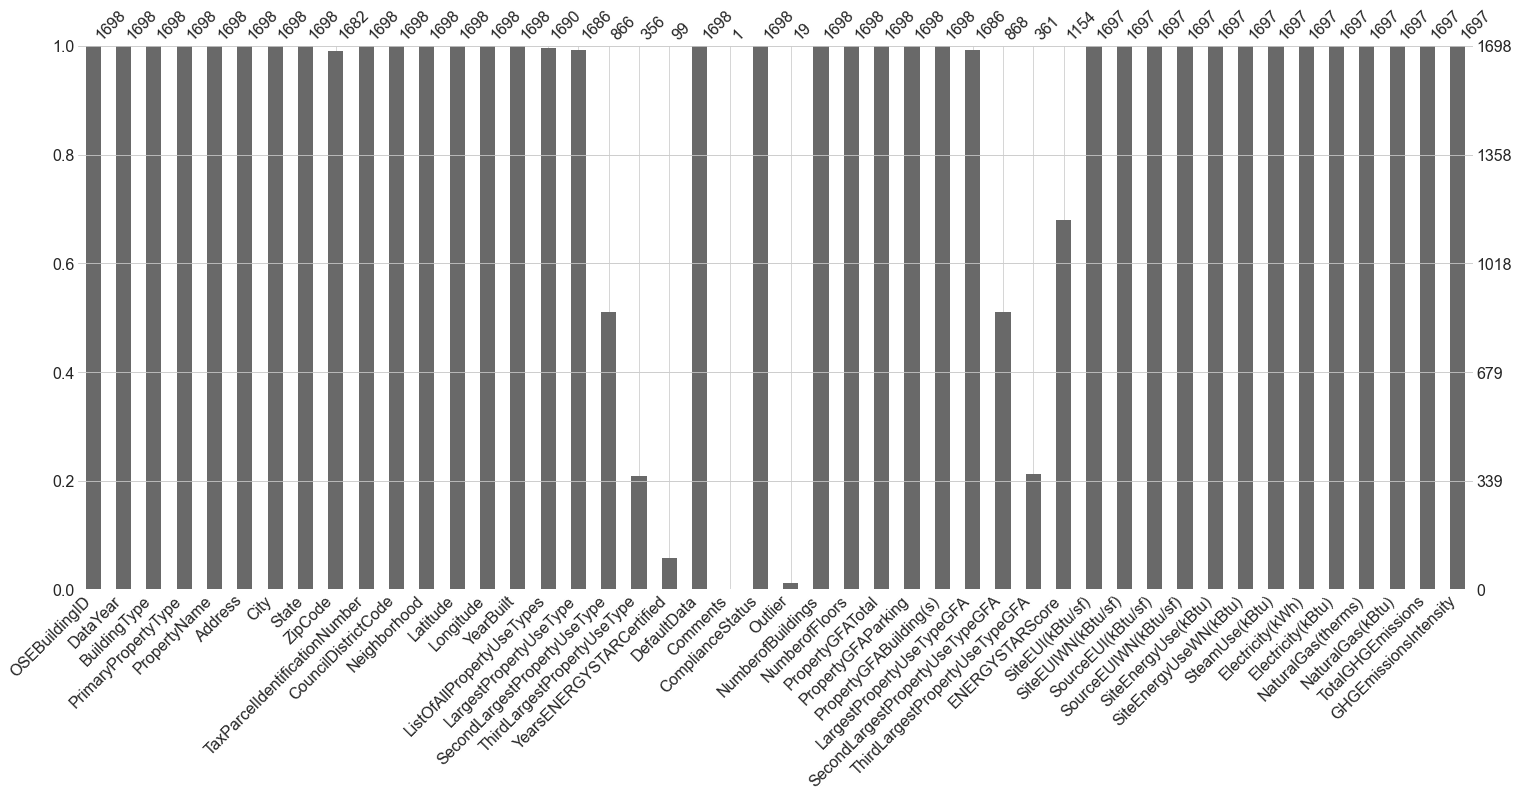

In [36]:
msno.bar(r_data)

<AxesSubplot:>

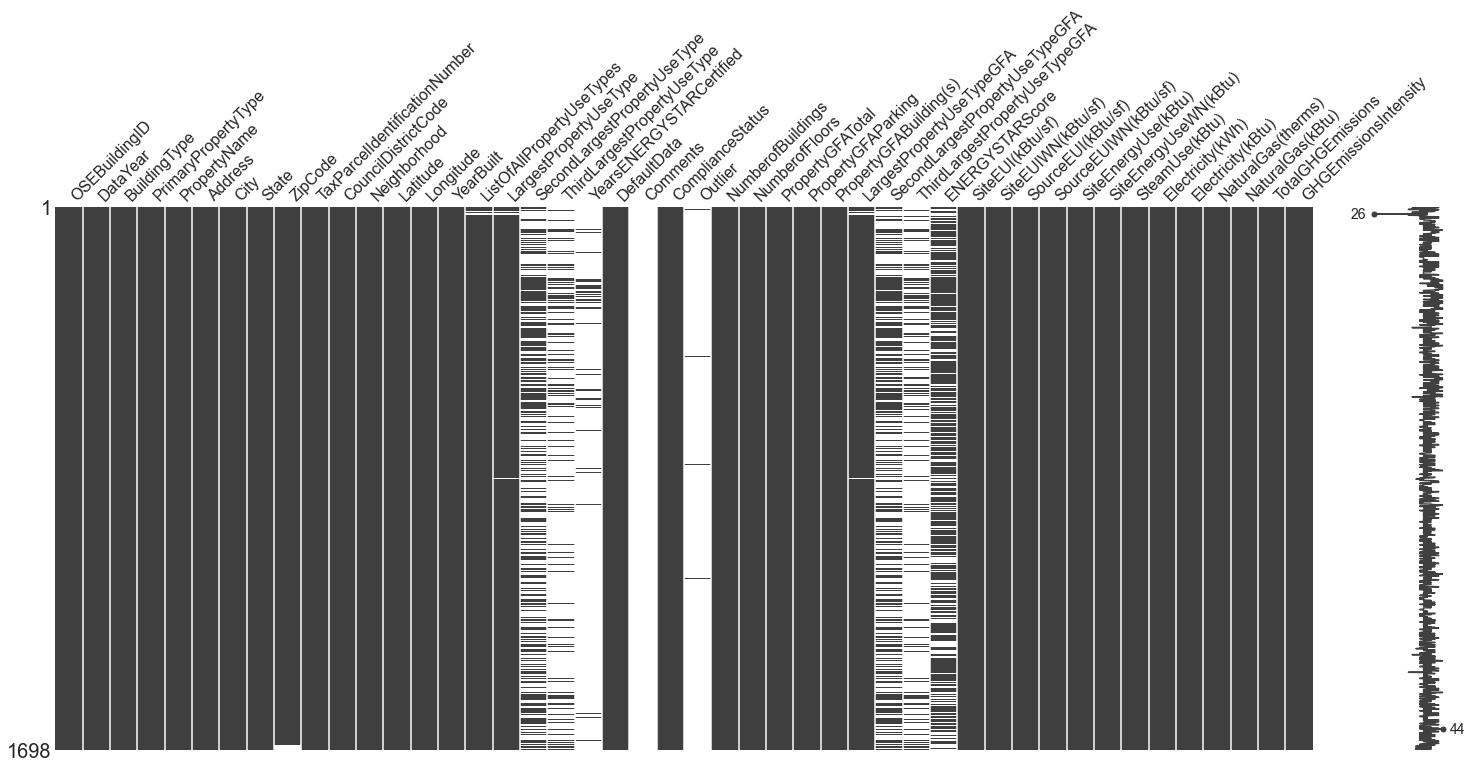

In [37]:
msno.matrix(r_data)

<AxesSubplot:>

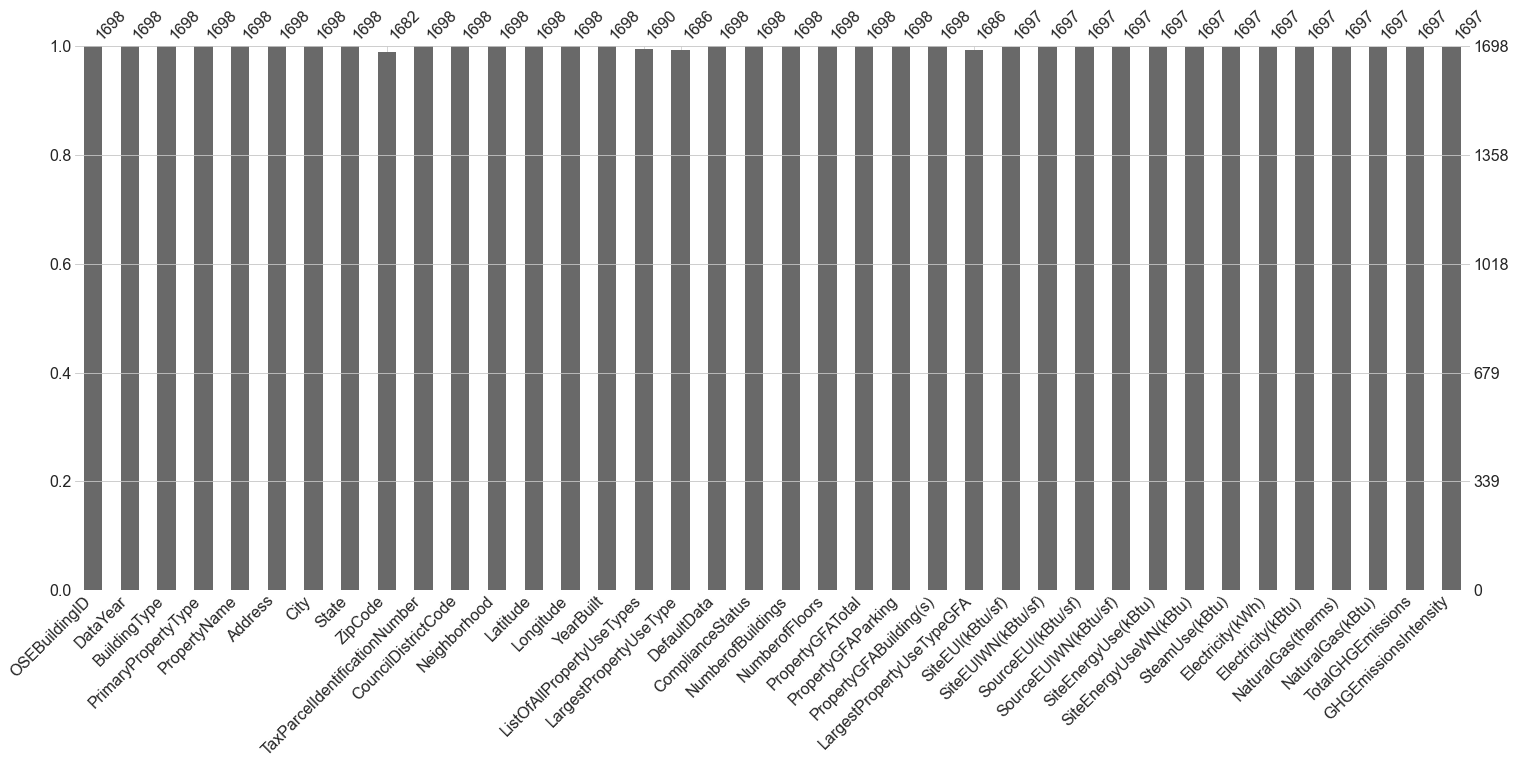

In [38]:
#Conserver "energy star score" pour dernière étape.
#Conserver uniquement les variables (colonnes) remplies à 80%.
energy_stscore = r_data['ENERGYSTARScore']
r_data = r_data.dropna(thresh = len(r_data)*0.8, axis=1)
msno.bar(r_data)

## Nettoyage: forte corrélation des variables explicatives<a class="anchor" id="corr"></a>

In [39]:

# Creer correlation matrix
mat_cor = r_data.corr().abs()

# Conserver triangle superieur de correlation matrix
upper = mat_cor.where(np.triu(np.ones(mat_cor.shape), k=1).astype(np.bool))

# trouver les variables avec des corrélations supérieurs à 90%:
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop



<ipython-input-39-41308a21396a>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = mat_cor.where(np.triu(np.ones(mat_cor.shape), k=1).astype(np.bool))


['PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)']

matrice des corrélations fortes:


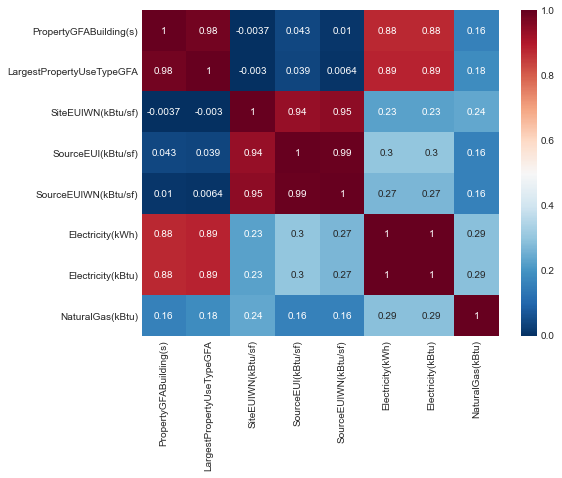

In [40]:
#calculer et observer les corrélations entre les variables
print("matrice des corrélations fortes:")
corr_df = r_data[to_drop].corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, cmap = 'RdBu_r', annot=True)
plt.show()

In [41]:
# variables redondantes: drop features pour nos modèles: 
to_drop = ['PropertyGFABuilding(s)',
           'LargestPropertyUseTypeGFA',
           'SiteEUIWN(kBtu/sf)',
           'SourceEUI(kBtu/sf)',
           'SourceEUIWN(kBtu/sf)',
           'Electricity(kWh)']
r_data.drop(to_drop, axis=1, inplace=True)

In [42]:
r_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698 entries, 0 to 1697
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1698 non-null   int64  
 1   DataYear                       1698 non-null   int64  
 2   BuildingType                   1698 non-null   object 
 3   PrimaryPropertyType            1698 non-null   object 
 4   PropertyName                   1698 non-null   object 
 5   Address                        1698 non-null   object 
 6   City                           1698 non-null   object 
 7   State                          1698 non-null   object 
 8   ZipCode                        1682 non-null   float64
 9   TaxParcelIdentificationNumber  1698 non-null   object 
 10  CouncilDistrictCode            1698 non-null   int64  
 11  Neighborhood                   1698 non-null   object 
 12  Latitude                       1698 non-null   f

## Nettoyage: intérêt faible des variables pour projet<a class="anchor" id="bof"></a>

In [43]:
r_data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'DefaultData', 'ComplianceStatus',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object')

In [44]:
#WN: weather normalised, NaturalGas: déja sous forme Kbtu
r_data.drop(['SiteEnergyUseWN(kBtu)','NaturalGas(therms)', 'DefaultData'], axis=1, inplace=True)


In [45]:
#réintroduction dans dataset d'enrgy star score avant traitement des lignes
r_data['ENERGYSTARScore'] = energy_stscore
r_data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'ComplianceStatus', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'ENERGYSTARScore'],
      dtype='object')

In [46]:
r_data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore
count,1698.000000,1698.000000,1682.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1.698000e+03,1698.000000,1697.000000,1.697000e+03,1.697000e+03,1.697000e+03,1.697000e+03,1697.000000,1697.000000,1154.000000
mean,16339.776207,2015.982332,98116.788347,4.369258,47.616140,-122.332925,1961.704947,1.148704,4.101885,1.183777e+05,13421.728504,72.104331,8.457072e+06,5.133132e+05,5.865634e+06,1.971806e+06,185.235053,1.501859,64.951906
std,13811.042261,0.131780,18.358883,2.191411,0.048065,0.024563,32.850343,2.810159,6.516620,2.951875e+05,42938.707728,73.490710,3.010387e+07,5.351773e+06,2.069226e+07,9.400898e+06,745.538021,2.266608,28.041709
min,1.000000,2015.000000,98006.000000,1.000000,47.499170,-122.411820,1900.000000,0.500000,0.000000,1.128500e+04,-1.000000,0.000000,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.120000,0.000000,1.000000
25%,584.250000,2016.000000,98105.000000,2.000000,47.585943,-122.343277,1930.000000,1.000000,1.000000,2.939250e+04,0.000000,32.900000,1.215360e+06,0.000000e+00,7.328030e+05,0.000000e+00,20.150000,0.275000,46.500000
50%,21161.000000,2016.000000,98109.000000,4.000000,47.612380,-122.333000,1965.000000,1.000000,2.000000,4.926600e+04,0.000000,51.700001,2.555917e+06,0.000000e+00,1.649172e+06,4.974050e+05,50.215000,0.785000,72.500000
75%,24601.750000,2016.000000,98124.000000,7.000000,47.649400,-122.321605,1989.000000,1.000000,4.000000,1.068380e+05,0.000000,82.450000,6.960904e+06,0.000000e+00,4.871044e+06,1.507822e+06,139.630000,1.765000,88.000000
max,50226.000000,2016.000000,98199.000000,7.000000,47.733870,-122.258640,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,834.400024,8.739237e+08,1.314066e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000,100.000000


## Nettoyage: individus (lignes) avec valeurs manquantes et outliers pour variables à prédire<a class="anchor" id="drop"></a>

In [47]:
#drop lignes manquantes dans nos var à prédire
r_data = r_data[~((r_data['SiteEnergyUse(kBtu)'].isnull()) | (r_data['TotalGHGEmissions'].isnull()))]

In [48]:
#zscore sup à trois écarts types
r_data = r_data[(np.abs(stats.zscore(r_data[['TotalGHGEmissions',
                                             'SiteEnergyUse(kBtu)']] ,
                                        nan_policy='omit')) < 3).all(axis=1)]

## 3. "Feature engineering" et traitement des données<a class="anchor" id="p2"></a>

## age des batiments à partir de l'année des données et l'année de construction<a class="anchor" id="âge"></a>

In [49]:
#age des batiments plutôt qu'année: feature engineering.
r_data['BuildingAge'] = r_data['DataYear'] - r_data['YearBuilt']
r_data.drop('YearBuilt', axis=1, inplace=True)

In [50]:
r_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1680 entries, 0 to 1697
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1680 non-null   int64  
 1   DataYear                       1680 non-null   int64  
 2   BuildingType                   1680 non-null   object 
 3   PrimaryPropertyType            1680 non-null   object 
 4   PropertyName                   1680 non-null   object 
 5   Address                        1680 non-null   object 
 6   City                           1680 non-null   object 
 7   State                          1680 non-null   object 
 8   ZipCode                        1664 non-null   float64
 9   TaxParcelIdentificationNumber  1680 non-null   object 
 10  CouncilDistrictCode            1680 non-null   int64  
 11  Neighborhood                   1680 non-null   object 
 12  Latitude                       1680 non-null   f

## Passage au log des targets<a class="anchor" id="log"></a>

In [51]:
r_data[['SiteEnergyUse(kBtu)']].describe

<bound method NDFrame.describe of       SiteEnergyUse(kBtu)
0            9.898724e+06
1            6.525887e+06
2            1.676022e+07
3            4.476997e+06
4            1.266246e+07
...                   ...
1693         8.497457e+05
1694         9.502762e+05
1695         5.765898e+06
1696         7.194712e+05
1697         1.152896e+06

[1680 rows x 1 columns]>

array([[<AxesSubplot:title={'center':'SiteEnergyUse(kBtu)'}>]],
      dtype=object)

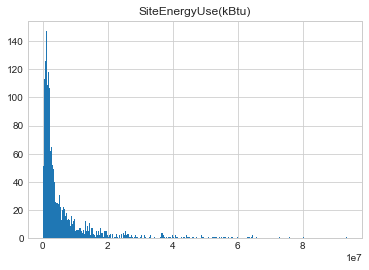

In [52]:
r_data[['SiteEnergyUse(kBtu)']].hist(bins=300)

In [53]:
#On passe au log pour espacer et "normaliser" les données: données et predictions plus lisibles
r_data['SiteEnergyUse(kBtu)'] = np.log(r_data['SiteEnergyUse(kBtu)'])

print(r_data[r_data['SiteEnergyUse(kBtu)'] < 0].head)

r_data.drop(r_data[r_data['SiteEnergyUse(kBtu)'] < 0].index, inplace = True)

r_data[r_data['SiteEnergyUse(kBtu)'] < 0]

<bound method NDFrame.head of     OSEBuildingID  DataYear       BuildingType PrimaryPropertyType  \
91             87      2016  SPS-District K-12         K-12 School   

                PropertyName              Address     City State  ZipCode  \
91  Arbor Heights Elementary  3701 S.W. 104th St.  Seattle    WA  98146.0   

   TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
91                    2518400005                    1    SOUTHWEST   47.5097   

    Longitude ListOfAllPropertyUseTypes LargestPropertyUseType  \
91 -122.37759               K-12 School            K-12 School   

   ComplianceStatus  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
91     Missing Data                1.0             2.0           53352.0   

    PropertyGFAParking  SiteEUI(kBtu/sf)  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
91                 0.0               0.0                 -inf             0.0   

    Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
91

C:\Users\Adnene\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,ListOfAllPropertyUseTypes,LargestPropertyUseType,ComplianceStatus,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore,BuildingAge


array([[<AxesSubplot:title={'center':'SiteEnergyUse(kBtu)'}>]],
      dtype=object)

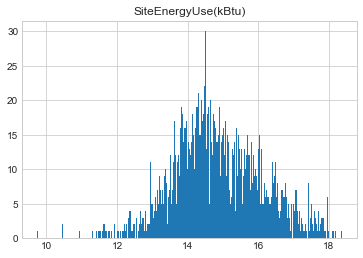

In [54]:
r_data[['SiteEnergyUse(kBtu)']].hist(bins=300)

array([[<AxesSubplot:title={'center':'TotalGHGEmissions'}>]], dtype=object)

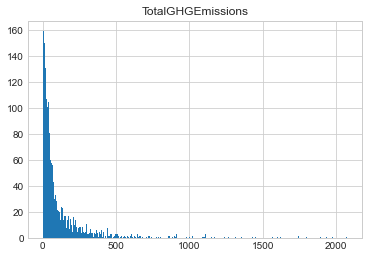

In [55]:
#idem pour total emissions carbonne :
r_data[['TotalGHGEmissions']].hist(bins=300)

In [56]:
r_data['TotalGHGEmissions'] = np.log(r_data['TotalGHGEmissions'])

print(r_data[r_data['TotalGHGEmissions'] < 0].head)

r_data.drop(r_data[r_data['TotalGHGEmissions'] < 0].index, inplace = True)

r_data[r_data['TotalGHGEmissions'] < 0]

<bound method NDFrame.head of       OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
10            19656      2015  NonResidential  Small- and Mid-Sized Office   
17            22138      2015  NonResidential             Worship Facility   
612             797      2016  NonResidential          Distribution Center   
768           20396      2016  NonResidential                    Warehouse   
797           20541      2016  NonResidential                        Other   
896           21315      2016  NonResidential  Small- and Mid-Sized Office   
938           21474      2016  NonResidential                        Other   
1013          22095      2016  NonResidential                    Warehouse   
1042          22547      2016  NonResidential        Self-Storage Facility   
1043          22548      2016  NonResidential        Self-Storage Facility   
1077          23020      2016  NonResidential        Self-Storage Facility   
1266          24547      2016  Non

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,ListOfAllPropertyUseTypes,LargestPropertyUseType,ComplianceStatus,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore,BuildingAge


array([[<AxesSubplot:title={'center':'TotalGHGEmissions'}>]], dtype=object)

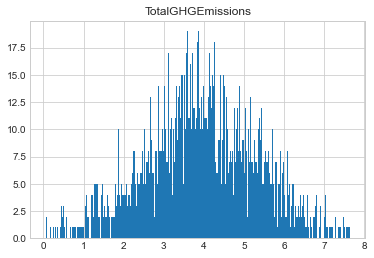

In [57]:
r_data[['TotalGHGEmissions']].hist(bins=300)

## séparation du dataframe par types de données<a class="anchor" id="sep"></a>

In [58]:
# projet: "L’objectif est de te passer des relevés de consommation annuels"
#séparer données annuels
annual_features = ['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(kBtu)','SiteEUI(kBtu/sf)']
r_data_annual = r_data[annual_features]
r_data.drop(annual_features, axis=1, inplace = True)


In [59]:
#séparer données d'identification
identification_features = ['OSEBuildingID', 'PropertyName', 'Address', 'ZipCode','City', 'State','TaxParcelIdentificationNumber', 'CouncilDistrictCode']
r_data_identification = r_data[identification_features]
r_data.drop(identification_features, axis=1, inplace = True)

## 4. Contrôle et export des données nettoyées<a class="anchor" id="p3"></a>

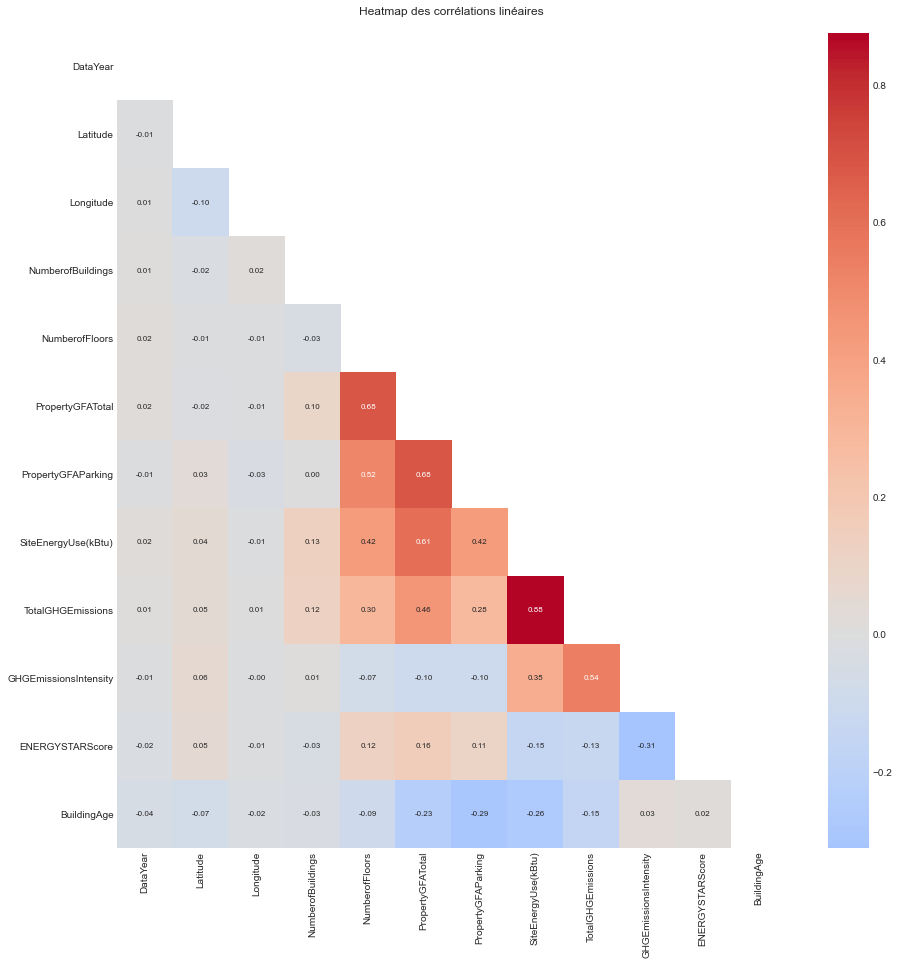

In [60]:
#calculer et observer les corrélations entre les variables: vérifier le nettoyage. Les deux variables à prédire 
#sont trés corrélés: pas de pblme pour nos prédictions.
corr = r_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

In [61]:
r_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662 entries, 0 to 1697
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DataYear                   1662 non-null   int64  
 1   BuildingType               1662 non-null   object 
 2   PrimaryPropertyType        1662 non-null   object 
 3   Neighborhood               1662 non-null   object 
 4   Latitude                   1662 non-null   float64
 5   Longitude                  1662 non-null   float64
 6   ListOfAllPropertyUseTypes  1655 non-null   object 
 7   LargestPropertyUseType     1651 non-null   object 
 8   ComplianceStatus           1662 non-null   object 
 9   NumberofBuildings          1662 non-null   float64
 10  NumberofFloors             1662 non-null   float64
 11  PropertyGFATotal           1662 non-null   float64
 12  PropertyGFAParking         1662 non-null   float64
 13  SiteEnergyUse(kBtu)        1662 non-null   float

<AxesSubplot:>

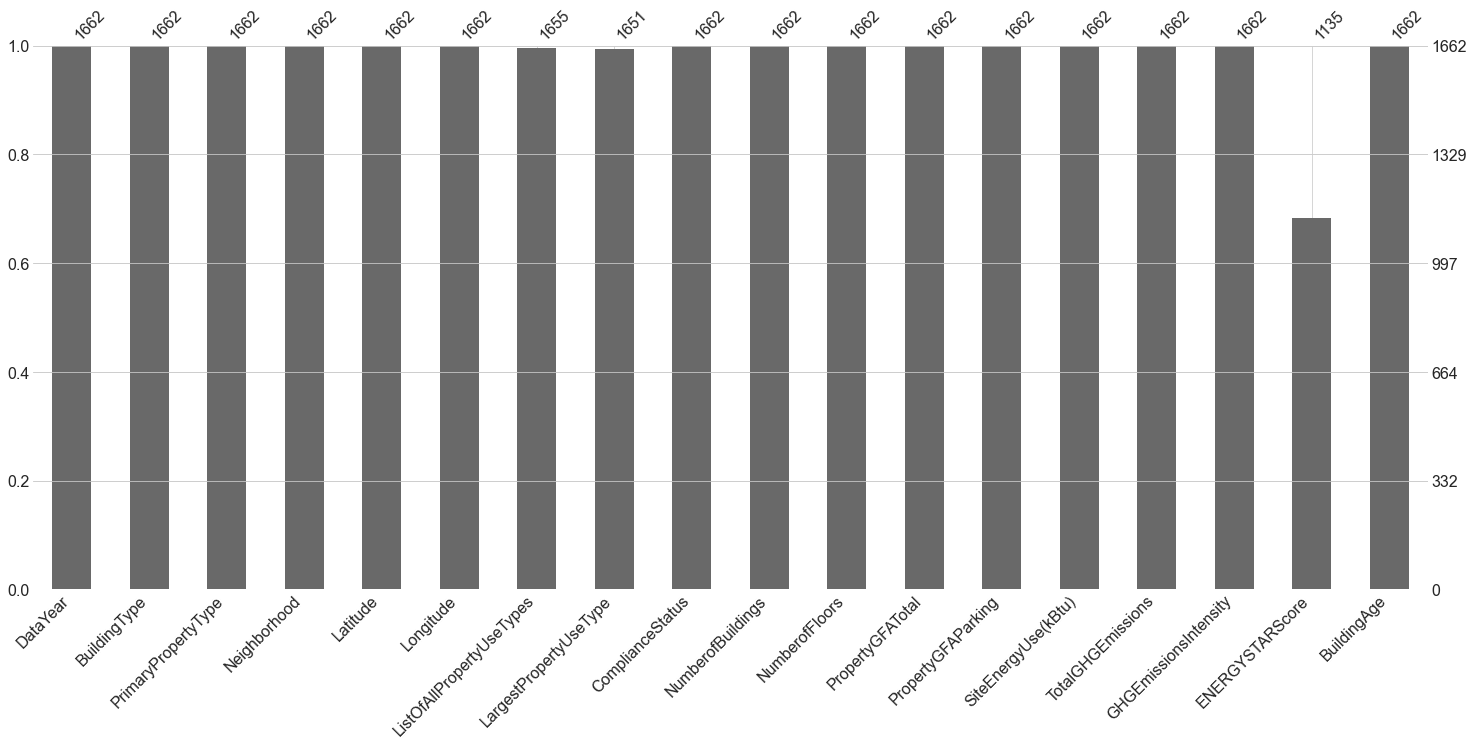

In [62]:
msno.bar(r_data)

In [63]:
perc_mv(r_data)

total valeurs manquantes: 545 


1.8217676159914427

In [64]:
#drop informations redondantes:
r_data.drop(['Neighborhood','DataYear'], axis=1, inplace=True)

In [65]:
num_data = r_data.select_dtypes(include=['int64','float64'])
cat_data = r_data.select_dtypes(exclude=['int64','float64']) 

In [66]:
cat_data.nunique()

BuildingType                   5
PrimaryPropertyType           24
ListOfAllPropertyUseTypes    374
LargestPropertyUseType        57
ComplianceStatus               4
dtype: int64

In [67]:
cat_data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'ComplianceStatus'],
      dtype='object')

In [68]:
num_data.columns

Index(['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ENERGYSTARScore',
       'BuildingAge'],
      dtype='object')

In [69]:
r_data.to_pickle("cleaned_data")